# Self-Attention

Written by Byung Chun Kim (wizardbc@gmail.com)

In [1]:
# !pip install lion_pytorch

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from lion_pytorch import Lion
import pandas as pd
import statsmodels.api as sm
plt.style.use('dark_background')

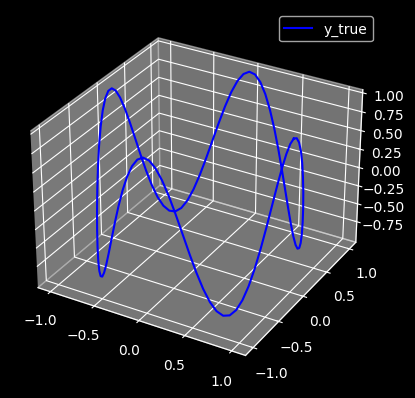

In [3]:
theta_linsp = np.linspace(0, 2*np.pi, 100)
x_circle = np.stack([np.cos(theta_linsp),np.sin(theta_linsp)], axis=-1)
y_circle = np.cos(4*theta_linsp)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.plot(x_circle[:,0], x_circle[:,1], y_circle, c='b', label='y_true')

# markerline, stemlines, baseline = ax.stem(x_circle[:,0], x_circle[:,1], y_circle, label='y_true')
# markerline.set_markerfacecolor('none')

plt.legend()
plt.show()

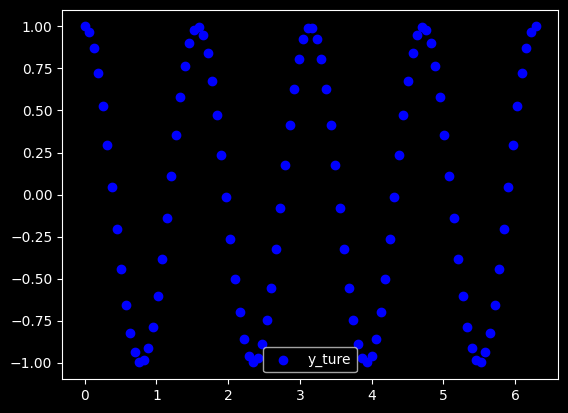

In [4]:
plt.scatter(theta_linsp, y_circle, c='b', label='y_ture')
plt.legend()
plt.show()

In [5]:
d = 10
sample = np.stack([y_circle[i:i+d] for i in range(100-d)])
x_trn = sample[:-1] + np.random.normal(size=(89,10))/20
y_trn = sample[1:] + np.random.normal(size=(89,10))/20

In [6]:
x_trn[0], y_trn[0]

(array([ 0.9782944 ,  0.98925645,  0.87371774,  0.75983225,  0.54427985,
         0.33796797, -0.03826337, -0.25114711, -0.36821662, -0.75075422]),
 array([ 0.92478704,  0.93987569,  0.72666569,  0.49970239,  0.35367023,
        -0.02633026, -0.16224765, -0.41399295, -0.62605802, -0.85157006]))

In [7]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

def frame(i):
  ax.clear()
  ax.set_xlim(0, 2*np.pi)
  ax.set_ylim(-1.1, 1.1)
  ax1 = ax.scatter(theta_linsp, y_circle, c='blue', alpha=0.5)
  ax2 = ax.scatter(theta_linsp[i:i+d], x_trn[i], alpha=0.5)
  ax3 = ax.scatter(theta_linsp[i+1:i+d+1], y_trn[i], alpha=0.5)
  return ax1, ax2, ax3

fig, ax = plt.subplots()
ani = FuncAnimation(fig, frame, frames=89)
plt.close()
ani

In [8]:
x_trn = torch.tensor(x_trn, dtype=torch.float32, device='cuda')
y_trn = torch.tensor(y_trn, dtype=torch.float32, device='cuda')

In [9]:
theta_new = np.linspace(2*np.pi, 4*np.pi, 100) - np.pi/3
sample_new = np.stack([np.cos(4*theta_new)[i:i+d] for i in range(100-d)])

x_tst = torch.tensor(sample_new[:-1], dtype=torch.float32, device='cuda')
y_tst = torch.tensor(sample_new[1:], dtype=torch.float32, device='cuda')

## MLP

In [10]:
class MLP(torch.nn.Module):
  def __init__(self, d_input=2, d_hidden=32, d_output=1):
    super().__init__()
    self.lin1 = torch.nn.Linear(d_input, d_hidden)
    self.lin2 = torch.nn.Linear(d_hidden, d_output)

  def forward(self, x):
    x = torch.tanh(self.lin1(x))
    x = self.lin2(x)
    return x

In [11]:
mlp = MLP(10,256,10)
mlp.cuda()

criterion = torch.nn.MSELoss(reduction='sum')
optimizer = Lion(mlp.parameters(), lr=0.001)

mlp.train()
for epoch in range(30000):
  y_prd = mlp(x_trn)
  loss = criterion(y_prd, y_trn)
  loss.backward()
  optimizer.step()
  if epoch % 1000 == 0:
    print(epoch, loss.item())
  optimizer.zero_grad()

0 518.2884521484375
1000 3.980208396911621
2000 2.649923324584961
3000 2.1470437049865723
4000 1.8804316520690918
5000 1.6406497955322266
6000 1.5154385566711426
7000 1.470543622970581
8000 1.3700968027114868
9000 1.3063621520996094
10000 1.2390748262405396
11000 1.1679003238677979
12000 1.097625494003296
13000 1.0894966125488281
14000 1.0485069751739502
15000 0.9766005277633667
16000 0.9436765909194946
17000 0.8943811655044556
18000 0.8912564516067505
19000 0.8688557147979736
20000 0.8353188633918762
21000 0.8564192056655884
22000 0.7853996753692627
23000 0.7241113781929016
24000 0.7395985126495361
25000 0.7743645906448364
26000 0.6982575058937073
27000 0.6900469064712524
28000 0.68980872631073
29000 0.6266684532165527


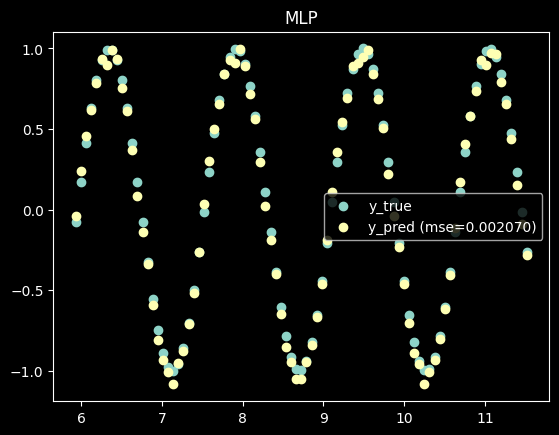

In [12]:
mlp.eval()

with torch.no_grad():
  y_pred = mlp(x_tst)
mse = ((y_tst[:,-1] - y_pred[:,-1])**2).mean()

plt.title("MLP")
plt.scatter(theta_new[11:], y_tst[:,-1].cpu().numpy(), label='y_true')
plt.scatter(theta_new[11:], y_pred[:,-1].cpu().numpy(), label=f'y_pred ({mse=:.6f})')
plt.legend()
plt.show()

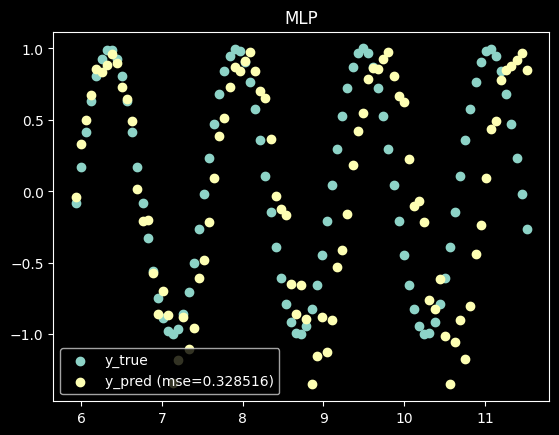

In [13]:
mlp.eval()

with torch.no_grad():
  y_pred = [x_tst[0].unsqueeze(0)]
  for _ in range(89):
    y_pred.append(mlp(y_pred[-1]))
  y_pred = torch.concat(y_pred, dim=0)[1:]
mse = ((y_tst[:,-1] - y_pred[:,-1])**2).mean()

plt.title("MLP")
plt.scatter(theta_new[11:], y_tst[:,-1].cpu().numpy(), label='y_true')
plt.scatter(theta_new[11:], y_pred[:,-1].cpu().numpy(), label=f'y_pred ({mse=:.6f})')
plt.legend()
plt.show()

## Self-Attention

In [14]:
attention = lambda Q,K,V: torch.matmul(torch.softmax(torch.matmul(Q,K.T)/np.sqrt(K.shape[0]), dim=-1), V)

class SelfAttnHead(torch.nn.Module):
  def __init__(self, d_m=2, d_k=2):
    super().__init__()
    self.linQ = torch.nn.Linear(d_m, d_k)
    self.linK = torch.nn.Linear(d_m, d_k)
    self.linV = torch.nn.Linear(d_m, d_k)

  def forward(self, q, k):
    q = self.linQ(q)
    k, v = self.linK(k), self.linV(k) # K와 V가 같다
    return attention(q,k,v)

In [21]:
attn_head = SelfAttnHead(d, d)
attn_head.cuda()

criterion = torch.nn.MSELoss(reduction='sum')
optimizer = Lion(attn_head.parameters(), lr=0.0001)

attn_head.train()
for epoch in range(30000):
  y_prd = attn_head(x_trn, x_trn)
  loss = criterion(y_prd, y_trn)
  loss.backward()
  optimizer.step()
  if epoch % 1000 == 0:
    print(epoch, loss.item())
  optimizer.zero_grad()

0 0.5369532704353333
1000 0.3462045192718506
2000 0.16630972921848297
3000 0.023550963029265404
4000 0.002935758326202631
5000 0.0026071073953062296
6000 0.0025248825550079346
7000 0.002473516156896949
8000 0.0024479266721755266
9000 0.002433129120618105
10000 0.002422119490802288
11000 0.002412981353700161
12000 0.0024050192441791296
13000 0.0023974194191396236
14000 0.0023899099323898554
15000 0.0023817229084670544
16000 0.002372974995523691
17000 0.002362485509365797
18000 0.0023502821568399668
19000 0.002337416633963585
20000 0.0023252826649695635
21000 0.002314754296094179
22000 0.00230523687787354
23000 0.0022970165591686964
24000 0.002290016273036599
25000 0.002284439280629158
26000 0.0022798485588282347
27000 0.002276256214827299
28000 0.0022733351215720177
29000 0.0022707267198711634


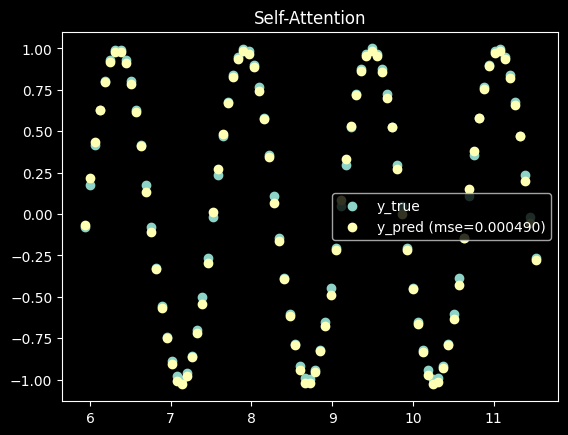

In [22]:
# 실제 관측값이 아닌 trn에서 노이즈만 제거해서 학습 
attn_head.eval()

with torch.no_grad():
  y_pred = attn_head(x_tst, x_trn)

mse = ((y_tst[:,-1] - y_pred[:,-1])**2).mean()

plt.title("Self-Attention")
plt.scatter(theta_new[11:], y_tst[:,-1].cpu().numpy(), label='y_true')
plt.scatter(theta_new[11:], y_pred[:,-1].cpu().numpy(), label=f'y_pred ({mse=:.6f})')
plt.legend()
plt.show()

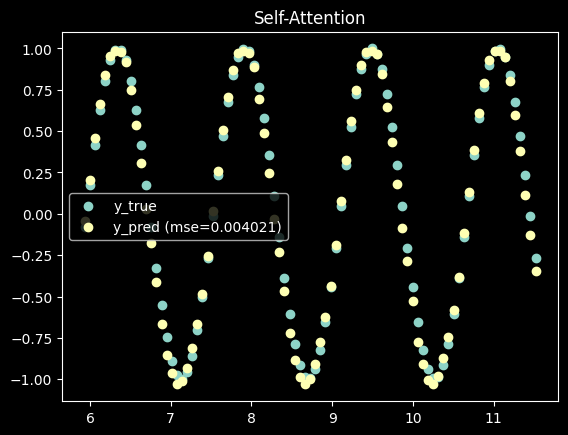

In [17]:
attn_head.eval()

with torch.no_grad():
  y_pred = [x_tst[0].unsqueeze(0)]
  for _ in range(89):
    y_pred.append(attn_head(y_pred[-1], x_trn))
  y_pred = torch.concat(y_pred, dim=0)[1:]

mse = ((y_tst[:,-1] - y_pred[:,-1])**2).mean()

plt.title("Self-Attention")
plt.scatter(theta_new[11:], y_tst[:,-1].cpu().numpy(), label='y_true')
plt.scatter(theta_new[11:], y_pred[:,-1].cpu().numpy(), label=f'y_pred ({mse=:.6f})')
plt.legend()
plt.show()

## Multi-Head Self-Attention

In [18]:
class MHSelfAttn(torch.nn.Module):
  def __init__(self, n_heads=4, d_k=2):
    super().__init__()
    d_m = n_heads * d_k
    self.n_heads = n_heads
    self.heads = torch.nn.ModuleList([SelfAttnHead(d_m, d_k) for _ in range(n_heads)])
    self.linO = torch.nn.Linear(d_m, d_m)

  def forward(self, q, k):
    outputs = [self.heads[i](q,k) for i in range(self.n_heads)]
    return self.linO(torch.concat(outputs, dim=-1))

In [19]:
multi_head = MHSelfAttn(8, 2)
multi_head.cuda()

criterion = torch.nn.MSELoss(reduction='sum')
optimizer = Lion(multi_head.parameters(), lr=0.0001)

attn_head.train()
for epoch in range(30000):
  y_prd = multi_head(x_trn, x_trn)
  loss = criterion(y_prd, y_trn)
  loss.backward()
  optimizer.step()
  if epoch % 1000 == 0:
    print(epoch, loss.item())
  optimizer.zero_grad()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (89x10 and 16x2)

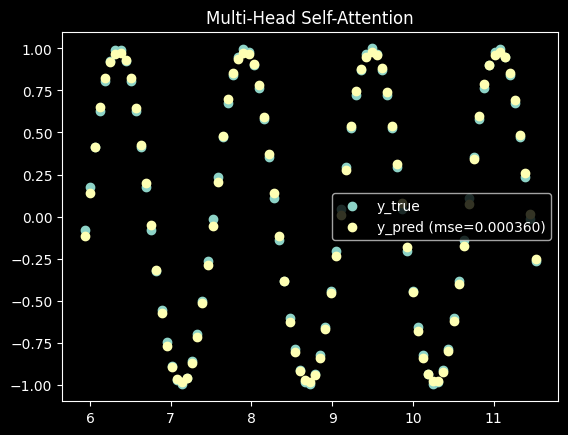

In [ ]:
multi_head.eval()

with torch.no_grad():
  y_pred = multi_head(x_tst, x_trn)

mse = ((y_tst[:,-1] - y_pred[:,-1])**2).mean()

plt.title("Multi-Head Self-Attention")
plt.scatter(theta_new[11:], y_tst[:,-1].cpu().numpy(), label='y_true')
plt.scatter(theta_new[11:], y_pred[:,-1].cpu().numpy(), label=f'y_pred ({mse=:.6f})')
plt.legend()
plt.show()

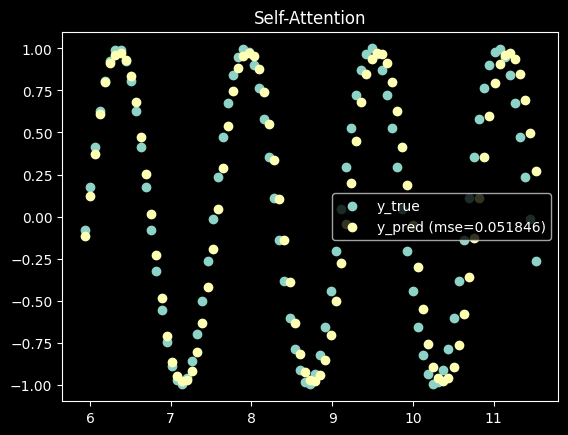

In [ ]:
multi_head.eval()

with torch.no_grad():
  y_pred = [x_tst[0].unsqueeze(0)]
  for _ in range(89):
    y_pred.append(multi_head(y_pred[-1], x_trn))
  y_pred = torch.concat(y_pred, dim=0)[1:]

mse = ((y_tst[:,-1] - y_pred[:,-1])**2).mean()

plt.title("Self-Attention")
plt.scatter(theta_new[11:], y_tst[:,-1].cpu().numpy(), label='y_true')
plt.scatter(theta_new[11:], y_pred[:,-1].cpu().numpy(), label=f'y_pred ({mse=:.6f})')
plt.legend()
plt.show()